The following notebook will get two different datasets of explanatory variables: temporal an non-temporal
related. 
In order to improve the speed time, this notebook will create the respective datasets and it will send a task to 
EarthEngine with a ReduceByRegion operation, we have proved that this method is faster than using the individual
calls to the API.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from pathlib import Path
import ee
from gee_scripts.get_sources import get_s1_image, get_gldas, get_gpm, get_hansen, get_gpm_sum
from gee_scripts.get_sources import get_srtm, get_globcover, get_gedi, get_gldas_stats, get_extra_non_temporal
from gee_scripts import init_ee
init_ee()

The objective would be to loop over the points or the dates...<br>
After testing this script https://code.earthengine.google.com/b18e876cca44266be704924b7354ddff <br>
I found out that the best way to do it is to loop over the dates, and then pass the reduceregions. <br>


# 1. Read data

In [25]:
df = pd.read_csv('data/field_data_unique_coords.csv', parse_dates=["date"])
assert df["date"].dtype == "datetime64[ns]"
len(df)

267218

In [21]:
requested_data = pd.read_csv("data/9_clean_training_data/all_training_data_with_extra_and_locations_and_precipSum.csv", parse_dates=["date"])
print(len(requested_data))
# get the points that were not requested yet by using the date and station_id
# requested_data["date"] = requested_data["date"].dt.date
# df["date"] = df["date"].dt.date
df = df[~df.set_index(["date", "id"]).index.isin(requested_data.set_index(["date", "id"]).index)]
len(df)

31547


235671

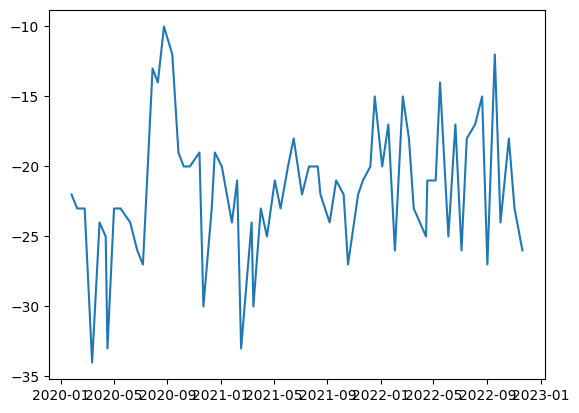

69


In [26]:
mti_10 = df[df.id=="10_MTI_MTI_H002_P1"].sort_values("date")

# plot gwl_cm against date
import matplotlib.pyplot as plt
plt.plot(mti_10["date"], mti_10["gwl_cm"])
plt.show()
print(len(mti_10))

In [24]:
mti_10[mti_10.date=="2021-02-16"]

,id,date,source,lon,lat,gwl_cm
7889,10_MTI_MTI_H002_P1,2021-02-16,pkeg,109.949795,-0.417562,-33.0


In [38]:
mti_10.date.dt.year.unique()

array([2020, 2021, 2022], dtype=int32)

In [15]:
requested_data[requested_data.id=="10_MTI_MTI_H002_P1"].sort_values("date")

,Unnamed: 0,source,id,date,gwl_cm,lat,lon,LIA,VH,VV,...,prec_30_sum,region_id,geometry,index_right,aoi_phu,island,phu_name,province,tile_id,phu_id
609,609,pkeg,10_MTI_MTI_H002_P1,2020-12-18,-19.0,-0.417562,109.949795,36.833565,-13.408387,-8.081711,...,103.679997,7,POINT (109.949795 -0.417562),256.0,KAL_User_11,Kalimantan,KHG Sungai Kapuas - Sungai Mendawak,West Kalimantan,11.0,256.0
610,610,pkeg,10_MTI_MTI_H002_P1,2021-02-16,-33.0,-0.417562,109.949795,36.835093,-13.942264,-9.721927,...,45.949999,7,POINT (109.949795 -0.417562),256.0,KAL_User_11,Kalimantan,KHG Sungai Kapuas - Sungai Mendawak,West Kalimantan,11.0,256.0
611,611,pkeg,10_MTI_MTI_H002_P1,2021-03-12,-24.0,-0.417562,109.949795,36.837024,-12.922000,-8.504655,...,86.619998,7,POINT (109.949795 -0.417562),256.0,KAL_User_11,Kalimantan,KHG Sungai Kapuas - Sungai Mendawak,West Kalimantan,11.0,256.0
612,612,pkeg,10_MTI_MTI_H002_P1,2021-06-16,-18.0,-0.417562,109.949795,36.834029,-12.141429,-8.024664,...,112.089997,7,POINT (109.949795 -0.417562),256.0,KAL_User_11,Kalimantan,KHG Sungai Kapuas - Sungai Mendawak,West Kalimantan,11.0,256.0
613,613,pkeg,10_MTI_MTI_H002_P1,2022-05-06,-21.0,-0.417562,109.949795,36.830001,-11.844378,-8.657506,...,114.729997,7,POINT (109.949795 -0.417562),256.0,KAL_User_11,Kalimantan,KHG Sungai Kapuas - Sungai Mendawak,West Kalimantan,11.0,256.0
614,614,pkeg,10_MTI_MTI_H002_P1,2022-11-02,-23.0,-0.417562,109.949795,36.834804,-11.977293,-7.981047,...,93.539998,7,POINT (109.949795 -0.417562),256.0,KAL_User_11,Kalimantan,KHG Sungai Kapuas - Sungai Mendawak,West Kalimantan,11.0,256.0


##########################
## Set type of output
##########################

In [5]:
# This notebook can be run entirely, if we want to task the orders to GEE we'll set this variable to True
send_task = True

##########################

In [6]:
unique_coords = df[["id", "lon", "lat"]].drop_duplicates()
unique_coords.head()
len(unique_coords)

# Convert them as a geodataframe and save them
geometry = [Point(xy) for xy in zip(unique_coords.lon, unique_coords.lat)]
gdf = gpd.GeoDataFrame(unique_coords, geometry=geometry)

In [7]:
# Read regions shapefile

# I have two regions, first is to only the high correlated stations and the second is all the stations
# I will use either depending on the dataset we have selected above

shp_path = Path("data/0_shp/")
region_path = "regions_to_request_explanatory_all.gpkg"

gdf_regions = gpd.GeoDataFrame.from_file(shp_path/region_path)
gdf_regions

,region_id,geometry
0,1,"MULTIPOLYGON (((96.37854 4.01317, 96.76923 3.9..."
1,2,"MULTIPOLYGON (((102.96446 -0.63790, 104.82488 ..."
2,3,"MULTIPOLYGON (((140.00836 -7.80760, 140.75163 ..."
3,4,"MULTIPOLYGON (((105.23245 -2.56075, 105.62785 ..."
4,5,"MULTIPOLYGON (((101.59551 1.61281, 101.45686 0..."
5,6,"MULTIPOLYGON (((100.69365 2.01094, 100.81080 2..."
6,7,"MULTIPOLYGON (((108.80424 1.60848, 109.83126 1..."
7,8,"MULTIPOLYGON (((110.98152 -2.86934, 114.00610 ..."
8,9,"MULTIPOLYGON (((132.99060 -0.68691, 133.43736 ..."
9,10,"MULTIPOLYGON (((116.84967 3.98347, 117.30926 3..."


In [ ]:
# # Remove those date where the gwl measure is out of reasonable range
# upper_thres = 20
# lower_thres = -100

# df = df[(df.gwl_cm < upper_thres) & (df.gwl_cm > lower_thres)]

# # Get the coordinates of the individual points

# unique_coords = df[["id", 'lon', 'lat']].drop_duplicates()
# len(df), len(unique_coords)

In [8]:
missing_coors = ['138_NBR_M13','18_SBA_DTD043','18_SBA_DTP002','18_SBA_DTP025','18_SBA_DTP031','18_SBA_DTP034','18_SBA_DTP038','18_SBA_DTP054','271_RSP_H19','BRG_140301_01','BRG_140302_01','BRG_140302_02','BRG_610117_01']

In [9]:
# Create geodataframe from x y coordinates
gdf_unique_coords = gpd.GeoDataFrame(unique_coords, geometry=gpd.points_from_xy(unique_coords.lon, unique_coords.lat), crs="EPSG:4326")

# Add the region id to each point
gdf_unique_coords = gpd.sjoin(gdf_unique_coords, gdf_regions[["region_id", "geometry"]], how="left", predicate="within")

In [10]:
# Failing datasets array(['BRG_150710_01', 'BRG_621107_03'], dtype=object)
gdf_unique_coords[gdf_unique_coords.id.isin(["BRG_621107_03", "BRG_150710_01"])]

,id,lon,lat,geometry,index_right,region_id
222645,BRG_150710_01,103.900168,-1.274317,POINT (103.90017 -1.27432),1,2
245948,BRG_621107_03,114.220600,-2.654022,POINT (114.22060 -2.65402),7,8


# 1. Get temporal explanatory variables

In [11]:
gdf_regions

,region_id,geometry
0,1,"MULTIPOLYGON (((96.37854 4.01317, 96.76923 3.9..."
1,2,"MULTIPOLYGON (((102.96446 -0.63790, 104.82488 ..."
2,3,"MULTIPOLYGON (((140.00836 -7.80760, 140.75163 ..."
3,4,"MULTIPOLYGON (((105.23245 -2.56075, 105.62785 ..."
4,5,"MULTIPOLYGON (((101.59551 1.61281, 101.45686 0..."
5,6,"MULTIPOLYGON (((100.69365 2.01094, 100.81080 2..."
6,7,"MULTIPOLYGON (((108.80424 1.60848, 109.83126 1..."
7,8,"MULTIPOLYGON (((110.98152 -2.86934, 114.00610 ..."
8,9,"MULTIPOLYGON (((132.99060 -0.68691, 133.43736 ..."
9,10,"MULTIPOLYGON (((116.84967 3.98347, 117.30926 3..."


In [12]:
gdf_unique_coords

,id,lon,lat,geometry,index_right,region_id
0,02_AHL_SBG-B076,117.007750,3.937760,POINT (117.00775 3.93776),9,10
65,02_AHL_SBG-B101,117.010120,3.931860,POINT (117.01012 3.93186),9,10
130,02_AHL_SBG-B103,117.005210,3.926090,POINT (117.00521 3.92609),9,10
195,02_AHL_SBG-C003,117.145430,3.903400,POINT (117.14543 3.90340),9,10
260,02_AHL_SBG-C006,117.148320,3.919380,POINT (117.14832 3.91938),9,10
...,...,...,...,...,...,...
266127,ij2,114.022576,-2.573375,POINT (114.02258 -2.57337),7,8
266206,jambi1,103.589975,-1.238478,POINT (103.58997 -1.23848),1,2
266449,kalbar1,109.394853,-0.210225,POINT (109.39485 -0.21022),6,7
266842,kalteng1,114.058131,-2.319728,POINT (114.05813 -2.31973),7,8


# 2. Get temporal explanatory

In [13]:
base_selectors = ["system:index", "lat", "lon", "id", "date"]
s1_selectors = ["LIA", "VH", "VV", "VVVH_ratio", "angle"]
gldas_selectors = ['sm_1', 'sm_3', 'sm_7', 'sm_30']
gpm_selectors = ['precipitation', 'prec_3', 'prec_7', 'prec_30']
gpm_selectors_sum = ['prec_3_sum', 'prec_7_sum', 'prec_30_sum']

def get_temporal_explanatory(region_id):
    """Get the explanatory temporal based variables"""

    region = gdf_regions[gdf_regions.region_id == region_id].to_crs("EPSG:4326")[:]
    dates = df[df.id.isin(gdf_unique_coords[gdf_unique_coords.region_id == region_id].id.unique())].date.unique()
    points = gdf_unique_coords[gdf_unique_coords.region_id == region_id][["id", "geometry", "lat", "lon"]].to_crs("EPSG:4326")

    # print(len(dates), len(points))
    # Convert to ee elements

    ee_dates = ee.FeatureCollection(ee.List([ ee.Feature(None, {"date": date}) for date in dates]))
    ee_points = ee.FeatureCollection(points.__geo_interface__)
    ee_region = ee.FeatureCollection(region.__geo_interface__)

    def get_sources(date_feature):

        date_range = ee.Date(date_feature.get("date")).getRange('day')

        s1_composite = get_s1_image(date_range, ee_region)

        return s1_composite.set({
         "numberOfBands" : s1_composite.bandNames().size(),
         "date" : ee.Date(date_feature.get("date"))
         })

    def reduce_composite(composite):

        # Filter the extra data with the matching date
        date = composite.get("date")
        date_range = ee.Date(date).getRange('day')

        gldas_composite = get_gldas(date_range, ee_region)
        gpm_composite = get_gpm(date_range, ee_region)
        gpm_sum_composite = get_gpm_sum(date_range, ee_region)

        composite = (ee.Image(composite)
            .addBands(gldas_composite)
            .addBands(gpm_composite)
            .addBands(gpm_sum_composite)
        )

        return composite.reduceRegions(**{
         "collection" : ee_points,
         "reducer" : ee.Reducer.first(),
         "scale" : 10,
         "tileScale" : 16
        }).filter(ee.Filter.notNull(['VH'])).map(lambda feature: feature.set({
         "date" : date
        }))


    task = (ee_dates
         .map(get_sources)
         .filter(ee.Filter.gt('numberOfBands', 0))
         .map(reduce_composite).flatten()
    )

    # task_name = f"All_temporal_non_resample_at_all_region_{region_id}_dates_{len(dates)}_points_{len(points)}_with_date_lon_lat"
    task_name = f"1_Precipitation_sum_non_resample_at_all_region_{region_id}_dates_{len(dates)}_points_{len(points)}_with_date_lon_lat"""


    ee_task = ee.batch.Export.table.toDrive(**{
      "collection": task, 
      "folder" : "INDONESIA_GWL",
      "description": task_name,
      "selectors": base_selectors + s1_selectors + gldas_selectors + gpm_selectors + gpm_selectors_sum

    })

    # Uncoment to start the task
    not send_task or ee_task.start()
    print("Exported" if send_task else "Not exported", task_name)
send_task = True
[get_temporal_explanatory(region_id) for region_id in gdf_regions.region_id.unique() if region_id in [8,7,2]] 

Exported 1_Precipitation_sum_non_resample_at_all_region_2_dates_1767_points_148_with_date_lon_lat
Exported 1_Precipitation_sum_non_resample_at_all_region_7_dates_1219_points_477_with_date_lon_lat
Exported 1_Precipitation_sum_non_resample_at_all_region_8_dates_1664_points_221_with_date_lon_lat


[None, None, None]

# 2.2 Get "yearly" temporal explanatory variables (Hansen)

In [40]:
hansen_selectors = ["year", "B3","B4","B5","B7","ndvi","ndmi","ndbri"]

# get all the years from the field data
years = sorted([y for y in df.date.dt.year.unique() if y != 2013] )

for year in years:

    points = df[["id", "lon", "lat"]].drop_duplicates()
    points = gpd.GeoDataFrame(points, geometry=gpd.points_from_xy(points.lon, points.lat), crs="EPSG:4326")
    ee_points = ee.FeatureCollection(points.__geo_interface__)

    image = get_hansen(year)

    result = image.reduceRegions(**{
        "collection" : ee_points,
        "reducer" : ee.Reducer.first(),
        "scale" : 30,
        "tileScale" : 16
    }).map(lambda feature: feature.set("year", str(year)))
    
    task_name = f"Hansen_year_{year}_points_{len(points)}_f"

    ee_task = ee.batch.Export.table.toDrive(**{
        "collection": result, 
        "folder" : "INDONESIA_GWL",
        "description": f"Hansen_year_{year}_points_{len(points)}_f",
        "selectors": base_selectors + hansen_selectors
    })

    # not send_task or ee_task.start()
    print("Exported" if send_task else "Not exported", task_name)


Exported Hansen_year_2018_points_2074_f
Exported Hansen_year_2019_points_2074_f
Exported Hansen_year_2020_points_2074_f
Exported Hansen_year_2021_points_2074_f
Exported Hansen_year_2022_points_2074_f
Exported Hansen_year_2023_points_2074_f


## 3. Get non temporal explanatory variables (others)

In [ ]:
# This dataset is not too computational expensive, so we are not forced to chunk it
# We'll try to get all the points at once, not by region (so we won't filter by region)
region = gdf_regions.to_crs("EPSG:4326")[:]
ee_region = ee.FeatureCollection(region.__geo_interface__)
points = gdf_unique_coords[["id", "geometry", "lat", "lon"]].rename(columns={"id": "id"}).to_crs("EPSG:4326")
ee_points = ee.FeatureCollection(points.__geo_interface__)
len(points)

In [ ]:
composite = (
    get_srtm()
        .addBands(get_globcover())
        .addBands(get_gedi(ee_region))
        .addBands(get_gldas_stats(ee_region))
)
composite.bandNames().getInfo()

result = composite.reduceRegions(**{
    "collection" : ee_points,
    "reducer" : ee.Reducer.first(),
    "scale" : 10,
    "tileScale" : 16
}).filter(ee.Filter.notNull(['canopy_height']))

task_name = f"All_Non_temporal_points_{len(points)}"

ee_task = ee.batch.Export.table.toDrive(**{
    "collection": result, 
    "folder" : "INDONESIA_GWL",
    "description":task_name,
    "selectors": base_selectors + ['elevation', 'aspect', 'slope', 'land_cov', 'canopy_height', "gldas_mean", "gldas_stddev"]
})

# Uncoment to start the task
not send_task or ee_task.start()
print("Exported" if send_task else "Not exported", task_name)

## 4. Get Extra Non temporal explanatory variables (others)

This data comes from https://code.earthengine.google.com/6c3eeb929a5ee8a42f55234b58796c0a


In [ ]:
composite = get_extra_non_temporal()
composite.bandNames().getInfo()

In [ ]:
phu = ee.FeatureCollection(
    "users/marortpab/FAO/SEPAL/2023_trainings/smm/AOI__Province__865_PHUs__INDONESIA"
)

result = composite.reduceRegions(**{
    "collection" : ee_points,
    "reducer" : ee.Reducer.first(),
    "scale" : 10,
    "tileScale" : 16
}).filter(ee.Filter.notNull(['distance']))

task_name = f"1_All_Non_temporal_extra_points_latlon_{len(points)}"

ee_task = ee.batch.Export.table.toDrive(**{
    "collection": result, 
    "folder" : "INDONESIA_GWL",
    "description":task_name,
    "selectors": base_selectors + ['distance', 'dir', 'acc']
})

# Uncoment to start the task
not send_task or ee_task.start()
print("Exported" if send_task else "Not exported", task_name)

# 4. Merge explanatory variables

## 4.1 Read temporal variables

In [ ]:
from pathlib import Path
import pandas as pd

In [30]:
explanatory_path = Path("data/7_training_data/")
dataset = "all"
temporal_file_names_groups = {
    "all" : [
        "All_temporal_non_resample_at_all_region_1_dates_520_points_24_with_date_lon_lat.csv",
        "All_temporal_non_resample_at_all_region_2_dates_1773_points_148_with_date_lon_lat.csv",
        "All_temporal_non_resample_at_all_region_3_dates_479_points_1_with_date_lon_lat.csv",
        "All_temporal_non_resample_at_all_region_4_dates_988_points_348_with_date_lon_lat.csv",
        "All_temporal_non_resample_at_all_region_5_dates_1796_points_717_with_date.csv",
        "All_temporal_non_resample_at_all_region_6_dates_489_points_43_with_date_lon_lat.csv",
        "All_temporal_non_resample_at_all_region_7_dates_1274_points_477_with_date_lon_lat.csv",
        "All_temporal_non_resample_at_all_region_8_dates_1671_points_220_with_date_lon_lat.csv",
        "All_temporal_non_resample_at_all_region_9_dates_379_points_17_with_date_lon_lat.csv",
        "All_temporal_non_resample_at_all_region_10_dates_846_points_77_with_date_lon_lat.csv",
    ]
}

# Dataset is the name of the type of data we're using (high_corr or all) (it's assigned at the beginning of the notebook)
temporal_file_names = temporal_file_names_groups[dataset]

# get and concatenate all the dataframes
temp_explanatory_dfs = pd.concat([
            pd.read_csv(explanatory_path/file_name) 
            for file_name 
            in temporal_file_names
        ], 
)

temp_explanatory_dfs["date"] = pd.to_datetime(temp_explanatory_dfs["date"])
temp_explanatory_dfs[temp_explanatory_dfs.id=="10_MTI_MTI_H002_P1"].sort_values("date").drop_duplicates("date")

# temp_explanatory_dfs

,system:index,lat,lon,id,date,LIA,VH,VV,VVVH_ratio,angle,sm_1,sm_3,sm_7,sm_30,precipitation,prec_3,prec_7,prec_30
32913,1021_7863,-0.417562,109.949795,10_MTI_MTI_H002_P1,2018-11-23,36.834518,-11.115489,-7.242387,0.111347,36.706898,33.959000,35.219625,35.243107,34.894550,0.035455,0.333333,0.796575,0.621709
33390,1033_7863,-0.417562,109.949795,10_MTI_MTI_H002_P1,2018-12-05,36.834287,-12.482840,-8.622993,0.080853,36.706669,33.483002,34.181167,34.488322,34.850171,0.098889,0.108966,0.508116,0.592630
33867,1045_7863,-0.417562,109.949795,10_MTI_MTI_H002_P1,2018-12-17,36.834229,-12.608877,-7.109794,0.139703,36.706589,34.060001,34.538500,35.024643,34.929154,0.012727,0.681562,0.481646,0.468615
34344,1057_7863,-0.417562,109.949795,10_MTI_MTI_H002_P1,2018-12-29,36.835271,-12.153513,-5.548560,0.217800,36.707634,33.717999,33.795542,33.821125,34.665650,1.317778,0.445333,0.251842,0.347121
34821,1069_7863,-0.417562,109.949795,10_MTI_MTI_H002_P1,2019-01-10,36.834222,-12.525175,-7.531102,0.120650,36.706589,34.707001,35.424000,34.640768,34.321454,1.051538,0.488857,0.841646,0.431288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5724,144_7863,-0.417562,109.949795,10_MTI_MTI_H002_P1,2023-05-01,36.832051,-11.607004,-8.266464,0.079986,36.704178,32.185001,32.462958,32.871946,32.724433,1.205556,1.611500,0.797255,0.255311
16218,462_7863,-0.417562,109.949795,10_MTI_MTI_H002_P1,2023-05-13,36.830081,-12.373931,-8.231820,0.092361,36.702198,32.855000,31.791083,32.481089,32.223500,0.002222,0.000909,0.184200,0.258990
25281,755_7863,-0.417562,109.949795,10_MTI_MTI_H002_P1,2023-06-06,36.833156,-11.572384,-7.258083,0.118390,36.705276,31.544001,32.471333,31.421232,31.648800,0.000000,0.046500,0.023250,0.115842
6201,147_7863,-0.417562,109.949795,10_MTI_MTI_H002_P1,2023-06-18,36.834282,-12.679203,-7.759344,0.113559,36.706413,32.015999,33.270500,33.183964,32.101617,0.000000,0.375909,0.382353,0.143350


In [29]:
# I modified the notebook on the 31/05/2024 to include the sum of the precipitation
temporal_precip_sum = {
    "all" : [
        "0_Precipitation_sum_non_resample_at_all_region_1_dates_520_points_24_with_date_lon_lat.csv",
        "0_Precipitation_sum_non_resample_at_all_region_2_dates_1773_points_148_with_date_lon_lat.csv",
        "0_Precipitation_sum_non_resample_at_all_region_3_dates_362_points_1_with_date_lon_lat.csv", # Using this there's only 362 where the other has 479
        "0_Precipitation_sum_non_resample_at_all_region_4_dates_988_points_348_with_date_lon_lat.csv",
        "0_Precipitation_sum_non_resample_at_all_region_5_dates_1796_points_718_with_date_lon_lat.csv",
        "0_Precipitation_sum_non_resample_at_all_region_6_dates_489_points_43_with_date_lon_lat.csv",
        "0_Precipitation_sum_non_resample_at_all_region_7_dates_1273_points_477_with_date_lon_lat.csv",
        "0_Precipitation_sum_non_resample_at_all_region_8_dates_1671_points_219_with_date_lon_lat.csv",
        "0_Precipitation_sum_non_resample_at_all_region_9_dates_379_points_17_with_date_lon_lat.csv",
        "0_Precipitation_sum_non_resample_at_all_region_10_dates_846_points_77_with_date_lon_lat.csv",
    ]
}

# Dataset is the name of the type of data we're using (high_corr or all) (it's assigned at the beginning of the notebook)
temporal_file_names = temporal_precip_sum[dataset]

# get and concatenate all the dataframes
temp_precip_sum = pd.concat([
            pd.read_csv(explanatory_path/file_name) 
            for file_name 
            in temporal_file_names
        ], 
)

temp_precip_sum["date"] = pd.to_datetime(temp_precip_sum["date"])
temp_precip_sum

temp_precip_sum[temp_precip_sum.id=="10_MTI_MTI_H002_P1"].sort_values("date").drop_duplicates("date")


,system:index,lat,lon,id,date,prec_3_sum,prec_7_sum,prec_30_sum
31482,978_7863,-0.417562,109.949795,10_MTI_MTI_H002_P1,2018-11-23,10.000000,58.149999,218.219996
31959,990_7863,-0.417562,109.949795,10_MTI_MTI_H002_P1,2018-12-05,3.160000,35.059999,193.789996
32436,1002_7863,-0.417562,109.949795,10_MTI_MTI_H002_P1,2018-12-17,21.810000,38.049999,152.299997
32913,1014_7863,-0.417562,109.949795,10_MTI_MTI_H002_P1,2018-12-29,13.360000,19.139999,112.119997
33390,1026_7863,-0.417562,109.949795,10_MTI_MTI_H002_P1,2019-01-10,17.109999,66.489998,140.599996
...,...,...,...,...,...,...,...,...
5724,144_7863,-0.417562,109.949795,10_MTI_MTI_H002_P1,2023-05-01,32.229999,40.659999,53.359999
16218,462_7863,-0.417562,109.949795,10_MTI_MTI_H002_P1,2023-05-13,0.020000,9.210000,53.869999
25281,755_7863,-0.417562,109.949795,10_MTI_MTI_H002_P1,2023-06-06,0.930000,0.930000,23.400000
6201,147_7863,-0.417562,109.949795,10_MTI_MTI_H002_P1,2023-06-18,8.270000,19.499999,28.669999


In [33]:
# # I modified the notebook on the 12/06/2024 to include the stations that we removed at the beginning
# # by applying the threshold of the gwl (20 and -100)
# missed_stations = {
#     "all" : [
#         "1_Precipitation_sum_non_resample_at_all_region_1_dates_444_points_24_with_date_lon_lat.csv",        
#         "1_Precipitation_sum_non_resample_at_all_region_2_dates_1767_points_148_with_date_lon_lat.csv",
#         "1_Precipitation_sum_non_resample_at_all_region_3_dates_421_points_1_with_date_lon_lat.csv",        
#         "1_Precipitation_sum_non_resample_at_all_region_4_dates_986_points_348_with_date_lon_lat.csv",
#         "1_Precipitation_sum_non_resample_at_all_region_5_dates_1799_points_718_with_date_lon_lat.csv",
#         "1_Precipitation_sum_non_resample_at_all_region_6_dates_430_points_43_with_date_lon_lat.csv",        
#         "1_Precipitation_sum_non_resample_at_all_region_7_dates_1219_points_477_with_date_lon_lat.csv",
#         "1_Precipitation_sum_non_resample_at_all_region_8_dates_1664_points_221_with_date_lon_lat.csv",
#         "1_Precipitation_sum_non_resample_at_all_region_9_dates_379_points_17_with_date_lon_lat.csv",        
#         "1_Precipitation_sum_non_resample_at_all_region_10_dates_780_points_77_with_date_lon_lat.csv",

#     ]
# }

# # Dataset is the name of the type of data we're using (high_corr or all) (it's assigned at the beginning of the notebook)
# missed_temporal_file_names = missed_stations[dataset]

# # get and concatenate all the dataframes
# missed_temp = pd.concat([
#             pd.read_csv(explanatory_path/file_name) 
#             for file_name 
#             in missed_temporal_file_names
#         ]
# )
# missed_temp["date"] = pd.to_datetime(missed_temp["date"])
# missed_temp



## 4.2 Read Hansen yearly variables

In [49]:
explanatory_path = Path("data/7_training_data/")
hansen_file_names = [
    "Hansen_year_2018_points_2075_f.csv",
    "Hansen_year_2019_points_2075_f.csv",
    "Hansen_year_2020_points_2075_f.csv",
    "Hansen_year_2021_points_2075_f.csv",
    "Hansen_year_2022_points_2075_f.csv",
    "Hansen_year_2023_points_2075_f.csv"
]

hansen_df = pd.concat([
    pd.read_csv(explanatory_path/file_name) 
    for file_name 
    in hansen_file_names
], axis=0)
print(len(hansen_df))

hansen_df[hansen_df.id=="10_MTI_MTI_H002_P1"].sort_values("date")

12450


,system:index,lat,lon,id,date,year,B3,B4,B5,B7,ndvi,ndmi,ndbri
1281,195104,-0.417562,109.949795,10_MTI_MTI_H002_P1,NaN,2018,17,83,62,26,0.660000,0.144828,0.522936
1281,195104,-0.417562,109.949795,10_MTI_MTI_H002_P1,NaN,2019,16,86,60,25,0.686275,0.178082,0.549550
1281,195104,-0.417562,109.949795,10_MTI_MTI_H002_P1,NaN,2020,16,82,59,24,0.673469,0.163121,0.547170
1281,195104,-0.417562,109.949795,10_MTI_MTI_H002_P1,NaN,2021,19,79,67,30,0.612245,0.082192,0.449541
1281,195104,-0.417562,109.949795,10_MTI_MTI_H002_P1,NaN,2022,16,83,57,23,0.676768,0.185714,0.566038
1281,195104,-0.417562,109.949795,10_MTI_MTI_H002_P1,NaN,2023,16,83,57,23,0.676768,0.185714,0.566038


## 4.3 Read non temporal explanatory

In [51]:
# As the non-temporal variables are the same for all the points, we just need to duplicate 
# their results into each of the dates of the points.
# i.e. 1 point with 10 dates will have the same non-temporal variables for each of the 10 dates.

non_temporal_file_name = "All_Non_temporal_points_2074.csv"
non_temporal_df = pd.read_csv(explanatory_path/non_temporal_file_name)
# drop lat and lon
non_temporal_df = non_temporal_df.drop(columns=["lat", "lon"])
non_temporal_df

non_temporal_df[non_temporal_df.id=="10_MTI_MTI_H002_P1"]


,system:index,id,elevation,aspect,slope,land_cov,canopy_height,gldas_mean,gldas_stddev
1281,195104,10_MTI_MTI_H002_P1,17,180.0,0.92741,160,12,31.02326,2.550106


## 4.4 Read extra non temporal explanatory (accumulation, distance to rivers/canals)

In [52]:
# As the non-temporal variables are the same for all the points, we just need to duplicate 
# their results into each of the dates of the points.
# i.e. 1 point with 10 dates will have the same non-temporal variables for each of the 10 dates.

non_temporal_extra_file_name = "All_Non_temporal_extra_points_latlon_2072.csv"
non_temporal_extra_df = pd.read_csv(explanatory_path/non_temporal_extra_file_name)
# drop lat and lon
non_temporal_extra_df = non_temporal_extra_df.drop(columns=["lat", "lon", "date"])
non_temporal_extra_df

non_temporal_extra_df[non_temporal_extra_df.id=="10_MTI_MTI_H002_P1"]


,system:index,id,distance,dir,acc
138,7863,10_MTI_MTI_H002_P1,6.230053,4,8


## 4.4 Create final explanatory variables dataset

In [53]:
len(temp_explanatory_dfs)

383290

In [54]:
# Merge the non-temporal variables with the temporal ones
explanatory_df = temp_explanatory_dfs.merge(non_temporal_df, on="id")
len(explanatory_df)

383668

In [55]:
# Merge with the extra non-temporal variables
explanatory_df = explanatory_df.merge(non_temporal_extra_df, on="id")
len(explanatory_df)

383564

In [56]:
explanatory_df.head()

,system:index_x,lat,lon,id,date,LIA,VH,VV,VVVH_ratio,angle,...,aspect,slope,land_cov,canopy_height,gldas_mean,gldas_stddev,system:index,distance,dir,acc
0,13_40018,3.809687,96.451939,121_APC_A21,2021-11-18,41.518192,-12.389068,-4.963172,0.261232,36.802202,...,258.714418,4.728601,12,5,36.231850,2.540359,40018,908.136558,16,4
1,13_40056,3.811906,96.468786,121_APC_B09,2021-11-18,37.709442,-11.907431,-5.864731,0.194680,35.960575,...,333.384155,4.142474,12,13,36.064407,2.701020,40056,2443.760544,64,1
2,13_40094,3.806685,96.459393,121_APC_B14,2021-11-18,35.779500,-12.803118,-5.593195,0.223412,35.960575,...,-0.000000,1.854334,12,14,36.157532,2.609480,40094,1800.220878,16,1
3,13_40132,3.855798,96.523820,121_APC_D11,2021-11-18,36.007309,-13.151474,-5.039535,0.264961,36.007309,...,-0.000000,0.000000,12,12,35.515514,3.326730,40132,6917.605585,4,1
4,13_40170,3.850565,96.515498,121_APC_D15,2021-11-18,37.853025,-14.973237,-4.171970,0.350833,36.007309,...,270.000000,1.858527,12,11,35.598789,3.224160,40170,7732.680924,16,17


In [57]:
# Merge hansen data with year and id
explanatory_df["year"] = explanatory_df.date.dt.year
hansen_df["year"] = hansen_df["year"].astype(int)
explanatory_df = explanatory_df.merge(hansen_df[["id"] + hansen_selectors], on=["id", "year"], how="left")

# I get more values here because I have requested Hansen for all the years
explanatory_df

,system:index_x,lat,lon,id,date,LIA,VH,VV,VVVH_ratio,angle,...,dir,acc,year,B3,B4,B5,B7,ndvi,ndmi,ndbri
0,13_40018,3.809687,96.451939,121_APC_A21,2021-11-18,41.518192,-12.389068,-4.963172,0.261232,36.802202,...,16,4,2021,18,93,69,28,0.675676,0.148148,0.537190
1,13_40056,3.811906,96.468786,121_APC_B09,2021-11-18,37.709442,-11.907431,-5.864731,0.194680,35.960575,...,64,1,2021,14,97,63,24,0.747748,0.212500,0.603306
2,13_40094,3.806685,96.459393,121_APC_B14,2021-11-18,35.779500,-12.803118,-5.593195,0.223412,35.960575,...,16,1,2021,14,97,63,23,0.747748,0.212500,0.616667
3,13_40132,3.855798,96.523820,121_APC_D11,2021-11-18,36.007309,-13.151474,-5.039535,0.264961,36.007309,...,4,1,2021,15,101,65,24,0.741379,0.216867,0.616000
4,13_40170,3.850565,96.515498,121_APC_D15,2021-11-18,37.853025,-14.973237,-4.171970,0.350833,36.007309,...,16,17,2021,15,96,61,22,0.729730,0.222930,0.627119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384315,840_5023,3.562450,117.137710,02_AHL_SSP-F153,2023-01-22,35.852239,-16.009284,-7.527672,0.151633,35.958145,...,16,1,2023,15,67,40,16,0.634146,0.252336,0.614458
384316,840_5088,3.542370,117.130950,02_AHL_SSP-F173,2023-01-22,35.036420,-12.622485,-7.525078,0.122134,35.958125,...,2,217,2023,21,63,56,25,0.500000,0.058824,0.431818
384317,840_5153,3.598300,117.201030,02_AHL_SSP-G032,2023-01-22,39.640818,-13.096971,-8.278228,0.099642,35.132320,...,128,2,2023,34,65,104,59,0.313131,-0.230769,0.048387
384318,840_5218,3.601620,117.193570,02_AHL_SSP-G044,2023-01-22,35.764655,-11.508965,-8.861900,0.059312,35.132320,...,32,5,2023,23,63,79,39,0.465116,-0.112676,0.235294


In [58]:
export_vars = [
    'id', 'date', 'LIA', 'VH', 'VV', 'VVVH_ratio',
    'angle', 'sm_1', 'sm_3', 'sm_7', 'sm_30', 'precipitation', 'prec_3',
    'prec_7', 'prec_30', 'elevation',
    'aspect', 'slope', 'land_cov', 'canopy_height', 'gldas_mean',
    'gldas_stddev', 'B3', 'B4',
    'B5', 'B7', 'ndvi', 'ndmi', 'ndbri',
    'distance', 'dir', 'acc',
]

In [85]:
explanatory_df[explanatory_df.id=="10_MTI_MTI_H002_P1"]


,system:index_x,lat,lon,id,date,LIA,VH,VV,VVVH_ratio,angle,...,dir,acc,year,B3,B4,B5,B7,ndvi,ndmi,ndbri
308171,22_7863,-0.417562,109.949795,10_MTI_MTI_H002_P1,2020-12-18,36.833565,-13.408387,-8.081711,0.109915,36.705654,...,4,8,2020,16,82,59,24,0.673469,0.163121,0.547170
308648,26_7863,-0.417562,109.949795,10_MTI_MTI_H002_P1,2021-02-16,36.835093,-13.942264,-9.721927,0.066269,36.707184,...,4,8,2021,19,79,67,30,0.612245,0.082192,0.449541
309125,27_7863,-0.417562,109.949795,10_MTI_MTI_H002_P1,2021-03-12,36.837024,-12.922000,-8.504655,0.090075,36.709137,...,4,8,2021,19,79,67,30,0.612245,0.082192,0.449541
309602,34_7863,-0.417562,109.949795,10_MTI_MTI_H002_P1,2021-06-16,36.834029,-12.141429,-8.024664,0.096518,36.706142,...,4,8,2021,19,79,67,30,0.612245,0.082192,0.449541
310079,55_7863,-0.417562,109.949795,10_MTI_MTI_H002_P1,2022-05-06,36.830001,-11.844378,-8.657506,0.070825,36.702110,...,4,8,2022,16,83,57,23,0.676768,0.185714,0.566038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348716,1223_7863,-0.417562,109.949795,10_MTI_MTI_H002_P1,2019-06-15,36.833245,-13.472192,-8.144538,0.108346,36.705658,...,4,8,2019,16,86,60,25,0.686275,0.178082,0.549550
349193,1235_7863,-0.417562,109.949795,10_MTI_MTI_H002_P1,2019-06-27,36.831727,-12.424261,-7.061309,0.139506,36.704136,...,4,8,2019,16,86,60,25,0.686275,0.178082,0.549550
349670,1247_7863,-0.417562,109.949795,10_MTI_MTI_H002_P1,2019-07-09,36.835784,-11.879229,-8.221197,0.085744,36.708195,...,4,8,2019,16,86,60,25,0.686275,0.178082,0.549550
350147,1259_7863,-0.417562,109.949795,10_MTI_MTI_H002_P1,2019-07-21,36.832694,-13.507758,-7.242590,0.144098,36.705101,...,4,8,2019,16,86,60,25,0.686275,0.178082,0.549550


# 4.5 Final step: Merge explanatory variables with response variable

In [88]:
explanatory_with_response_var = df[["source", "id", "date", "gwl_cm", "lat", "lon"]].merge(
    explanatory_df[export_vars], on=["id", "date"]
)

# Add day of the year as a variable
explanatory_with_response_var["doy"] = explanatory_with_response_var.date.dt.dayofyear
# explanatory_with_response_var.to_csv("data/7_training_data/explanatory_with_response_var_and_source_extra.csv", index=False)
len(explanatory_with_response_var)

36170

# 4.6 Final step: Add the extra "accumulated precipitation" variable

In [81]:
# merge explanatory_with_response_var with the one that caomes with the sum of the 
# accumulated precipitation
explanatory_with_response_var = pd.read_csv("data/7_training_data/explanatory_with_response_var_and_source_extra.csv")
print(len(explanatory_with_response_var))

explanatory_with_response_var[explanatory_with_response_var.id=="10_MTI_MTI_H002_P1"]


36170


,source,id,date,gwl_cm,lat,lon,LIA,VH,VV,VVVH_ratio,...,B4,B5,B7,ndvi,ndmi,ndbri,distance,dir,acc,doy
610,pkeg,10_MTI_MTI_H002_P1,2020-12-18,-19.0,-0.417562,109.949795,36.833565,-13.408387,-8.081711,0.109915,...,82,59,24,0.673469,0.163121,0.547170,6.230053,4,8,353
611,pkeg,10_MTI_MTI_H002_P1,2021-02-16,-33.0,-0.417562,109.949795,36.835093,-13.942264,-9.721927,0.066269,...,79,67,30,0.612245,0.082192,0.449541,6.230053,4,8,47
612,pkeg,10_MTI_MTI_H002_P1,2021-03-12,-24.0,-0.417562,109.949795,36.837024,-12.922000,-8.504655,0.090075,...,79,67,30,0.612245,0.082192,0.449541,6.230053,4,8,71
613,pkeg,10_MTI_MTI_H002_P1,2021-06-16,-18.0,-0.417562,109.949795,36.834029,-12.141429,-8.024664,0.096518,...,79,67,30,0.612245,0.082192,0.449541,6.230053,4,8,167
614,pkeg,10_MTI_MTI_H002_P1,2022-05-06,-21.0,-0.417562,109.949795,36.830001,-11.844378,-8.657506,0.070825,...,83,57,23,0.676768,0.185714,0.566038,6.230053,4,8,126
615,pkeg,10_MTI_MTI_H002_P1,2022-11-02,-23.0,-0.417562,109.949795,36.834804,-11.977293,-7.981047,0.095756,...,83,57,23,0.676768,0.185714,0.566038,6.230053,4,8,306


In [64]:
explanatory_with_response_var["date"] = pd.to_datetime(explanatory_with_response_var["date"])

In [65]:
explanatory_with_response_plus_precip = explanatory_with_response_var.merge(
    temp_precip_sum[['id', 'date', "prec_3_sum","prec_7_sum","prec_30_sum"]], 
    on=["id", "date"]
)

In [66]:
explanatory_with_response_plus_precip[explanatory_with_response_plus_precip.id=="10_MTI_MTI_H002_P1"]

,source,id,date,gwl_cm,lat,lon,LIA,VH,VV,VVVH_ratio,...,ndvi,ndmi,ndbri,distance,dir,acc,doy,prec_3_sum,prec_7_sum,prec_30_sum
609,pkeg,10_MTI_MTI_H002_P1,2020-12-18,-19.0,-0.417562,109.949795,36.833565,-13.408387,-8.081711,0.109915,...,0.673469,0.163121,0.547170,6.230053,4,8,353,14.92,28.449999,103.679997
610,pkeg,10_MTI_MTI_H002_P1,2021-02-16,-33.0,-0.417562,109.949795,36.835093,-13.942264,-9.721927,0.066269,...,0.612245,0.082192,0.449541,6.230053,4,8,47,0.07,0.150000,45.949999
611,pkeg,10_MTI_MTI_H002_P1,2021-03-12,-24.0,-0.417562,109.949795,36.837024,-12.922000,-8.504655,0.090075,...,0.612245,0.082192,0.449541,6.230053,4,8,71,1.27,39.719999,86.619998
612,pkeg,10_MTI_MTI_H002_P1,2021-06-16,-18.0,-0.417562,109.949795,36.834029,-12.141429,-8.024664,0.096518,...,0.612245,0.082192,0.449541,6.230053,4,8,167,0.42,13.900000,112.089997
613,pkeg,10_MTI_MTI_H002_P1,2022-05-06,-21.0,-0.417562,109.949795,36.830001,-11.844378,-8.657506,0.070825,...,0.676768,0.185714,0.566038,6.230053,4,8,126,11.60,22.260000,114.729997
614,pkeg,10_MTI_MTI_H002_P1,2022-11-02,-23.0,-0.417562,109.949795,36.834804,-11.977293,-7.981047,0.095756,...,0.676768,0.185714,0.566038,6.230053,4,8,306,1.09,7.740000,93.539998


In [ ]:
explanatory_with_response_plus_precip.to_csv("data/7_training_data/explanatory_with_response_var_and_source_extra_sum_prec.csv", index=False)